In [1]:
%matplotlib notebook

import os
from datetime import datetime
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import geojson

from satnogs_api_client import *

from utils import download_and_cache_data, \
                  parse_start_end_time, \
                  timestamp_from_filename, \
                  merge_date_ranges
    
from geojson_utils import ground_track_features, \
                          ground_station_features

In [2]:
norad_id = 25544 # ISS
start = datetime(2018, 10, 27, 0, 0)
end = datetime(2018, 10, 29, 23, 59)
base_dir = './SSTV_2018October'
prod = True
sstv_transmitter_uuids = ['qW5N27QuSrN2JMasbNiUhR', # Mode V Imaging
                          'xHu5MSMute88ReidipFupe'] # TEMP Off-Frequency SSTV

In [3]:
observations_all, ground_stations = download_and_cache_data(norad_id, start, end, base_dir, prod=prod)
ground_station_ids = set(map(lambda gs: gs['id'], ground_stations))

In [4]:
iss = fetch_satellite_data(norad_cat_id=25544)
iss

{'norad_cat_id': 25544,
 'name': 'ISS',
 'names': 'ZARYA',
 'image': 'https://db.satnogs.org/media/satellites/ISS.jpg',
 'status': 'alive'}

In [5]:
print('Transmitters in DB(-prod)')
transmitters = fetch_transmitters(norad_id=25544, url=satnogs_api_client.DB_BASE_URL)
print('{:23s} Description'.format('UUID'))
for transmitter in transmitters:
    print('{}  {}'.format(transmitter['uuid'], transmitter['description']))

Transmitters in DB(-prod)
UUID                    Description
4Yp5mRhdNPURqAuVn77NMk  Mode V/V AFSK Packet
jAkJ2yf46z8Kup5Yu8vita  Mode V/U FM Voice
ZJxCeQmih9zDfYNVrB4wRN  Mode V APRS
qW5N27QuSrN2JMasbNiUhR  Mode V Imaging
yMufCB474YJ4YRdDepfMUk  Mode U/V FM Voice
PjfcFc4PZ8M8n3thuyA6x9  Mode V/V FM (crew R2+3)
pQRPwTWqQr7unDav5Mz4pG  Mode V/V FM (crew R1)
4ACt6xLkArN9jyBMVmY6Bm  Tomsk-TPU-120 - Deployed in outer space
yPvKr7jdJZLHsHukp8dDQF  Mode U APRS Digi
EvtcWByczLm3LejfbGt8pS  Soyuz Communication - FMN
ZmxED2vRmJR3LnsgfARLsd  Tanusha FM
xHu5MSMute88ReidipFupe  TEMP Off-Frequency SSTV


In [6]:
# Statistics only!
# (doesn't modify the data)

# overview of the fetched observations
observations1 = list(filter(lambda o: (o['transmitter']  in sstv_transmitter_uuids), observations_all))


observations_failed1 = list(filter(lambda o: o['vetted_status'] == 'failed', observations1))
observations_bad1 = list(filter(lambda o: o['vetted_status'] == 'bad', observations1))
observations_unknown1 = list(filter(lambda o: o['vetted_status'] == 'unknown', observations1))
observations_good1 = list(filter(lambda o: o['vetted_status'] == 'good', observations1))
observations_data1 = list(filter(lambda o: o['demoddata'], observations_good1))

print('Ground Stations: {}'.format(len(ground_stations)))
print('\nObservations:')
print("DATA/GOOD/UNKNOWN/BAD/FAILED = {}/{}/{}/{}/{}".format(len(observations_data1),
                                                             len(observations_good1),
                                                             len(observations_unknown1),
                                                             len(observations_bad1),
                                                             len(observations_failed1)))

Ground Stations: 72

Observations:
DATA/GOOD/UNKNOWN/BAD/FAILED = 277/304/0/288/16


In [7]:
# Filter SSTV-only observations
observations_sstv = list(filter(lambda o: (o['transmitter']  in sstv_transmitter_uuids),
                                observations_all))

# Filter good SSTV-only observations with images
observations = list(filter(lambda o: (o['vetted_status'] == 'good'
                                      and o['demoddata']),
                           observations_sstv))

In [8]:
# Extract received image events
# and store them in `data_events`
data_events = []
for observation in observations:
    for demod_data in observation['demoddata']:
        try:
            t = timestamp_from_filename(demod_data['payload_demod'])

            data_events.append({'date': t,
                                'observation_id': observation['id'],
                                'ground_station': observation['ground_station'],
                                'payload_demod': demod_data['payload_demod']})
        except ValueError:
            pass
            print("Couldn't parse '{}'.".format(payload_demod.path))

In [9]:
# Map ground_stations to y-values
cat_dict = dict(zip(ground_station_ids, range(1, len(ground_station_ids)+1)))

# map y-values to categories
val_dict = dict(zip(range(1, len(ground_station_ids)+1), list(map(lambda gs: gs['name'], ground_stations))))

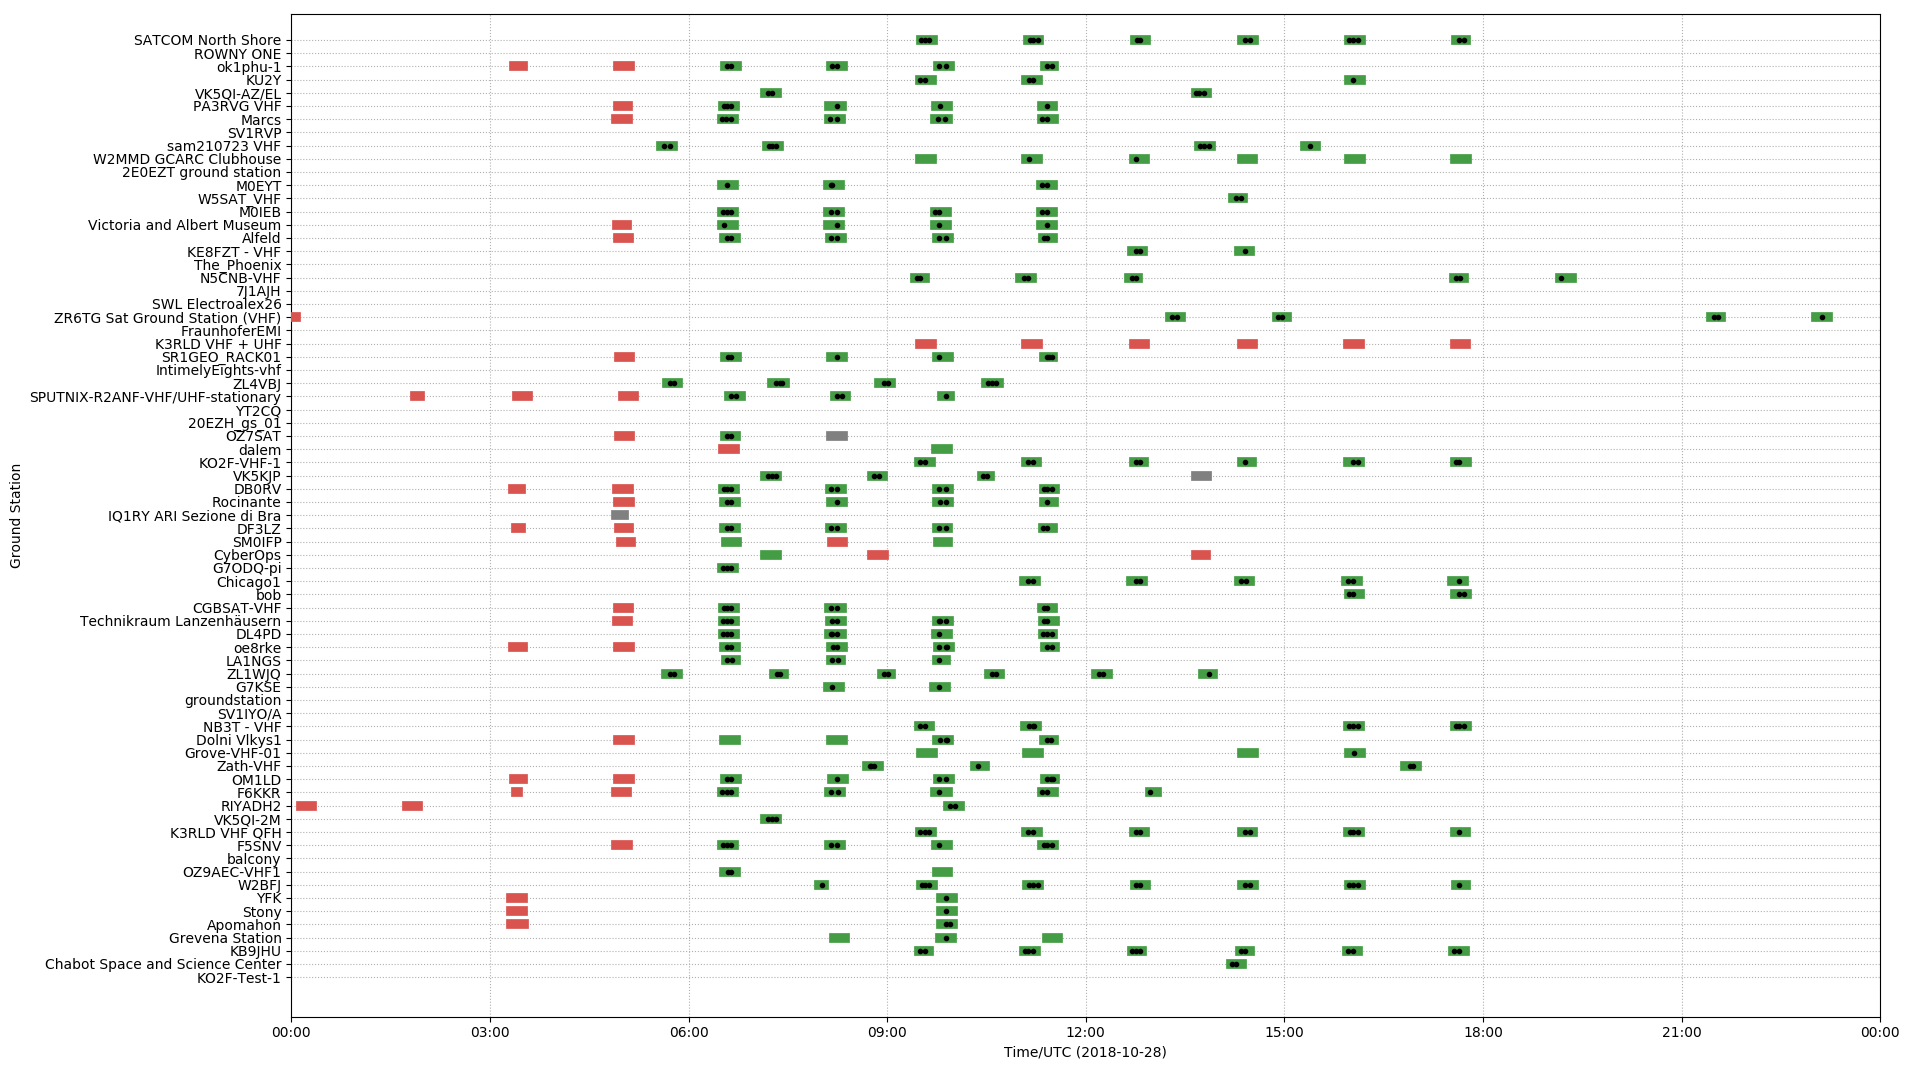

In [10]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as fc

def plot_coverage(observations,
                  data_events,
                  cat_dict,
                  val_dict,
                  ground_station_ids,
                  timespan=None,
                  out_file=None):
    plt.rcParams["figure.figsize"] = [1.2*16, 1.2*9]
    
    fig = plt.Figure()
    canvas = fc(fig)
    ax = fig.add_subplot(111)

    status_colors = {'good':     '#449d44',
                     'bad':      '#d9534f',
                     'failed':   'gray',    # normally: '#444000',
                     'unvetted': '#FF8C00'} # normally: darkorange

    y_offset = 0
    for observation in observations:
        yy = ([*parse_start_end_time(observation)],
              [cat_dict[observation['ground_station']]+y_offset, cat_dict[observation['ground_station']]+y_offset])
        ax.plot(*yy, c=status_colors[observation['vetted_status']], lw=7, zorder=5)

    for event in data_events:
        ax.scatter(event['date'], cat_dict[event['ground_station']], c='black', marker='.', zorder=10)
        
    # Set xaxis label format
    xfmt = mdates.DateFormatter('%H:%M')
    ax.xaxis.set_major_formatter(xfmt)
    
    if timespan:
        ax.set_xlim(timespan)

    # format y-ticks look up the categories
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: val_dict.get(x)))
    ax.set_yticks(range(1, len(ground_station_ids)+1))
    ax.set_ylim([-2,len(ground_station_ids)+2])

    ax.set_xlabel('Time/UTC ({:%Y-%m-%d})'.format(timespan[0]))
    ax.set_ylabel('Ground Station')

    ax.grid(linestyle='dotted')

    
    fig.tight_layout()

    if out_file:
        fig.savefig(out_file)
        
    return fig

fig = plot_coverage(observations_sstv,
                    data_events,
                    cat_dict,
                    val_dict,
                    ground_station_ids,
                    timespan=[datetime(2018,10,28),
                              datetime(2018,10,29)],
                    out_file=None)
display(fig)

In [11]:
timespans = [[datetime(2018,10,27), datetime(2018,10,28)],
             [datetime(2018,10,28), datetime(2018,10,29)],
             [datetime(2018,10,29), datetime(2018,10,30)]]
for timespan in timespans:
    filename = os.path.join('SSTV_2018October', timespan[0].strftime('%Y%m%d_coverage.svg'))
    
    fig = plot_coverage(observations_sstv,
                        data_events,
                        cat_dict,
                        val_dict,
                        ground_station_ids,
                        timespan=timespan,
                        out_file=filename)
    print('Generated {}'.format(filename))

Generated SSTV_2018October/20181027_coverage.svg
Generated SSTV_2018October/20181028_coverage.svg
Generated SSTV_2018October/20181029_coverage.svg


In [12]:
def create_event_geojson(observations, ground_stations, tle):
    # Filter ground stations
    ground_station_ids_good = set(map(lambda o: o['ground_station'], observations))
    ground_stations_good = list(filter(lambda gs: gs['id'] in ground_station_ids_good, ground_stations))

    # Create ground station GeoJSON feature collection
    gs_features = ground_station_features(ground_stations)

    # Calculate non-overlapping, continuous observation windows
    observation_timespans = merge_date_ranges((parse_start_end_time(observation) for observation in observations_sstv))

    # Calculate satellite ground track (using pyephem)
    sat_features = ground_track_features(tle, observation_timespans, feature_properties=iss)

    # Combine ground station and satellite features
    collection = geojson.FeatureCollection([*gs_features, *sat_features])
    
    return collection

In [13]:
filename = os.path.join(base_dir, 'event.geojson')

if os.path.isfile(filename):
    print('Use cached data')
    # Load cached data from local filesystem
    with open(filename, 'r') as f:
        collection = json.load(f)
else:
    print('Cache missed')
    # Get the TLE used by one of the observations
    tle1 = 'ISS (ZARYA)'
    [tle2, tle3] = fetch_tle_of_observation(observations[0]['id'], prod)
    tle = [tle1,tle2,tle3]

    # Create event geojson (markers for ground stations, lines for ground tracks during the observations)
    collection = create_event_geojson(observations_sstv, ground_stations, tle)

    # Convert GeoJSON collection into a string
    # collection_str = geojson.dumps(collection, sort_keys=True)
    
    with open(filename, 'w') as f:
        json.dump(collection, f)

Use cached data


In [14]:
# Display the GeoJSON file
import folium


# Create a map
m = folium.Map(location=[0,10],
               zoom_start=2)

# listening stations
# sat ground track
folium.GeoJson(
    collection,
    name='geojson'
).add_to(m)
m